In [31]:
# Preparing inputs, variables, and data

import numpy as np # scientific computing 
import scipy.io
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from sklearn import linear_model
from sklearn import svm 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import StratifiedKFold
import pandas as pd # data manipulation 
import brainiak.funcalign.srm
import brainiak.funcalign.rsrm
from brainiak import image, io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline 
import time

# descriptive variables for the dataset 
# the data consists of 1976 total TRs (time repetitions, i.e. when a single image was taken) for 17 participants
# taken in 2 separate (but concatenated) runs. 
# experimenters further identified 50 different scenes within this time period, and labelled whether or not
# participants recalled those scenes during a later recall task 
nScenes = 50
nScenes1 = 27
nTRs1 = 946 
nScenes2 = 23
nTRs2 = 1030
n = 17

# for each participant (of 17), let's get the recall data for each of 50 scenes 
# 3 variables (columns): recalled (1/0), quality (0-5), recall time len (0+)
recall_dfs = []
recall_path = "SherlockData/recall_transcripts/"
for pid in range(1, 18):
    filename = "NN_S" + str(pid) + "_Scene_Matches_edit4matlab.xlsx"
    file = pd.read_excel(recall_path + filename)
    file = file.replace(np.nan, -1, regex=True)
    quality = []
    recalled = []
    duration = []
    for s in range(50):
        if file['quality'][s] == -1: # did not recall
            quality.append(0)
            recalled.append(0)
            duration.append(0)
        else:
            quality.append(file['quality'][s])
            recalled.append(1)
            duration.append(file['end time sec'][s] - file['start time sec'][s])
    recall_dfs.append(np.transpose([recalled, quality, duration]))
    
recall_dfs = np.array(recall_dfs)

# Brain data: 17 participants, 26k WB mask voxels, 1976 TRs (time-of-repetition, i.e. one time point/1.5s in this case)
movie_data = []
for pid in range(1, 18):
    moviedat = np.load("SherlockData/movie_masked/movie_wb_S" + str(pid) + ".npz")['data']
    # stored as TR x voxel, but we want voxel x TR data 
    movie_data.append(np.transpose(moviedat))
    
movie_data = np.array(movie_data)

In [2]:
# zscores each of list of 2D arrays, by row
# For each participant, we want to compare how the voxel activations change over time, 
# rather than the absolute voxel activations 
def zscore(data):
    for pid in range(len(data)):
        data[pid] = np.nan_to_num(stats.zscore(data[pid], axis = 1, ddof = 1))
    return np.array(data)

# Downsampling function (features x TRs -> features x SCENES)
# given data matrix of 1 participant (features x TRs)
# returns a features x SCENEs matrix, where 
# corresponding TRs in a scene are averaged 
# if rh is True, then movie data corresponds to only the right brain and thus we want to 
# add in
movieTRs = np.array(pd.read_csv("movieTRs.csv", index_col = 0))
def scene_voxelavg(dat_tr, startind = 0, endind = nScenes, rh = False):
    dat_sc = []
    for sceneidx in range(startind, endind):
        offset = 1
        if rh:
            offset = offset + nTRs1
        startTR = movieTRs[sceneidx, 1] - offset
        endTR = movieTRs[sceneidx, 2] - offset
        response_avg = np.reshape(np.mean(dat_tr[:,startTR:endTR + 1], axis = 1), (-1, 1))
        if len(dat_sc) == 0:
            dat_sc = response_avg
        else:
            dat_sc = np.append(dat_sc, response_avg, axis = 1)
    return np.array(dat_sc)

# given a participant index and
# recalltype (0 for nRecall, 1 for time of recall, 2 for quality of recall)
# returns a nTRs-len vector representation for recall from start scene index
# i.e. expands a recall outcome vector from length SCENES to TRs
# note that this is a very imprecise way of identifying recall, as it is possible that 
# participants recalled only parts of the scene and not others
def get_recall_labels(pidx, recalltype, startind = 0, endind = nScenes):
    labels_byTR = []
    startTR = movieTRs[startind, 1] - 1 
    for sceneidx in range(startind, endind):
        endTR = movieTRs[sceneidx, 2] - 1 
        labels_byTR = np.append(labels_byTR, 
            np.repeat(recall_dfs[pidx, sceneidx, recalltype], endTR-startTR+1))
        startTR = endTR + 1
    return labels_byTR

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


In [3]:
# Diffusion Mapping 
# takes data matrix (observations are ROWS), bandwidth, and time
# and returns [map vals] using the first m non-trivial coordinate functions
# and their corresponding eigenvalues 
def diffmap(xs, sigma, t, m):
    dists = squareform(pdist(xs))
    W = np.exp(-1 * np.power(dists, 2) / (2 * np.power(sigma, 2)))
    M = W / np.sum(W, axis = 1)[:, np.newaxis]
    evals, evecs = eigs(M, m + 1)
    evals = np.real(evals[1:(m + 1)])
    evecs = np.real(evecs[:, 1:(m + 1)])
    
    return [evecs * np.power(evals, t), evals]

In [123]:
srm = brainiak.funcalign.srm.SRM(n_iter = 10, features = 128)
srm.fit(zscore(movie_data))
shared_data = srm.transform(movie_data)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


In [124]:
# Participants' brain data downsampled such that for each voxel we have observations across
# number of SCENES, not TRs, recalled - this is the original information given about participant recalls
scene_dat = [scene_voxelavg(shared_data[i], 0) for i in range(n)]

# transform a list of n (feat x scene) matrices to a single flat (n * scene x feat) matrix to use as input
def flatdat(dat):
    flat = dat[0]
    for i in range(1, len(dat)):
        flat = np.append(flat, dat[i], axis = 1)
    return np.array(flat.T) 
sharedscene_flat = flatdat(scene_dat)

In [125]:
# labels for the scenes 
scene_labels = np.linspace(0, nScenes, nScenes + 1)[:-1]
for pid in range(1, n):
    scene_labels = np.append(scene_labels, np.linspace(0, nScenes, nScenes + 1)[:-1])
scene_labels = np.ravel([int(i) for i in scene_labels])
np.shape(scene_labels)

(850,)

In [132]:
# How well can we predict the scene with different dimensions?
# If we predicted randomly, it would be 1/50 = 2% chance of getting it right (we'll check empirically as well)
# (We'll use sigma = 100 and time = 1, based on findings from the visualizations)

classifier = GaussianNB() # KNeighborsClassifier() does just as well! 
[dif_map, dif_vals] = diffmap(sharedscene_flat, 100, 1, 128)

results_dim = []
null_dim = []
for i in range(8):
    results = []
    nullresults = []
    
    dim = 2 ** i
    X = dif_map[:, :dim]
    y = scene_labels
    
    skf = StratifiedKFold(n_splits = 5) # 50 classes, only 17 examples each...
    skf.get_n_splits(X, y)
    for train_idx, test_idx in skf.split(X, y):
        trainx = X[train_idx, :]
        testx = X[test_idx, :]
        
        trainy = y[train_idx]
        testy = y[test_idx]
        
        classifier.fit(trainx, np.ravel(np.random.choice(trainy, len(trainy), replace = False)))
        nullpreds = classifier.predict(testx)
        nullresults.append(np.mean(nullpreds == testy))
        
        classifier.fit(trainx, trainy)
        preds = classifier.predict(testx)
        results.append(np.mean(preds == testy))
        
    print(dim, np.shape(X), np.shape(y), np.round(np.mean(results), 3), np.round(np.mean(nullresults), 3))
    results_dim.append(results)
    null_dim.append(nullresults)


1 (850, 1) (850,) 0.071 0.026
2 (850, 2) (850,) 0.135 0.009
4 (850, 4) (850,) 0.474 0.002
8 (850, 8) (850,) 0.694 0.021
16 (850, 16) (850,) 0.819 0.023
32 (850, 32) (850,) 0.909 0.023
64 (850, 64) (850,) 0.92 0.012
128 (850, 128) (850,) 0.88 0.029


In [133]:
results_dim

[[0.075, 0.085, 0.08, 0.04, 0.07333333333333333],
 [0.125, 0.145, 0.16, 0.12, 0.12666666666666668],
 [0.495, 0.535, 0.44, 0.4066666666666667, 0.49333333333333335],
 [0.675, 0.72, 0.72, 0.6533333333333333, 0.7],
 [0.785, 0.855, 0.8666666666666667, 0.8, 0.7866666666666666],
 [0.905, 0.915, 0.9733333333333334, 0.88, 0.8733333333333333],
 [0.91, 0.915, 0.96, 0.9333333333333333, 0.88],
 [0.86, 0.875, 0.9266666666666666, 0.9, 0.84]]

Text(0.5, 1.0, 'Accuracy of scene prediction by \n number of dimensions used in diffusion embedding \n (with SRM shared space data and Gaussian Naive Bayes model)')

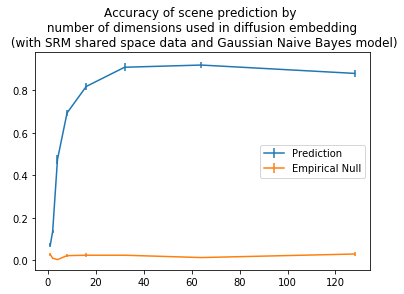

In [134]:
# plt.plot(2 ** np.linspace(0, 8, 9)[:-1], np.mean(results_dim, axis = 1))
plt.errorbar(2 ** np.linspace(0, 8, 9)[:-1], np.mean(results_dim, axis = 1), np.std(results_dim, axis = 1)/np.sqrt(np.shape(results_dim)[1] - 1))
# plt.plot(2 ** np.linspace(0, 8, 9)[:-1], np.mean(null_dim, axis = 1))
plt.errorbar(2 ** np.linspace(0, 8, 9)[:-1], np.mean(null_dim, axis = 1), np.std(null_dim, axis = 1)/np.sqrt(np.shape(null_dim)[1] - 1))
plt.legend(["Prediction", "Empirical Null"])
plt.title("Accuracy of scene prediction by \n number of dimensions used in diffusion embedding \n (with SRM shared space data and Gaussian Naive Bayes model)")

In [155]:
# Compare with Whole-Brain data performance:

# Participants' brain data downsampled such that for each voxel we have observations across
# number of SCENES, not TRs, recalled - this is the original information given about participant recalls
zmovie_data = zscore(movie_data)
scene_dat = [scene_voxelavg(zmovie_data[i], 0) for i in range(n)]
scene_flat = flatdat(scene_dat)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


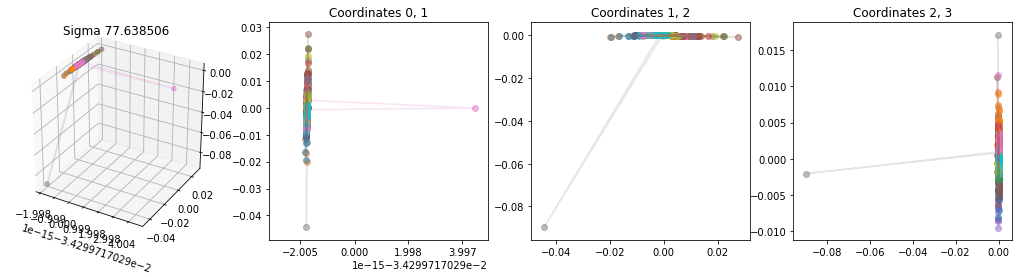

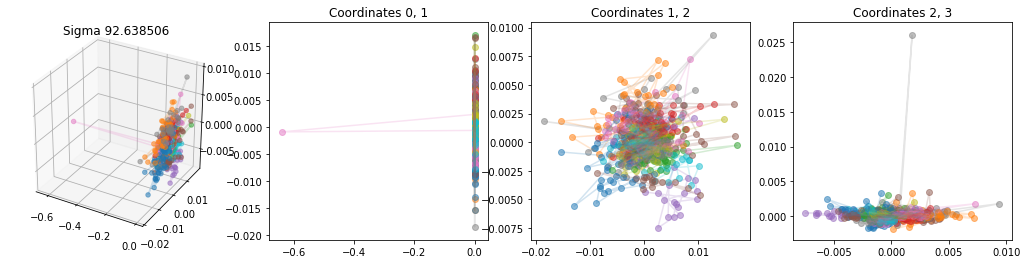

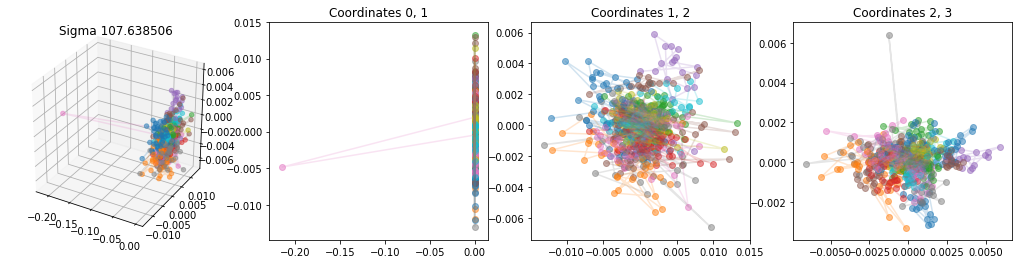

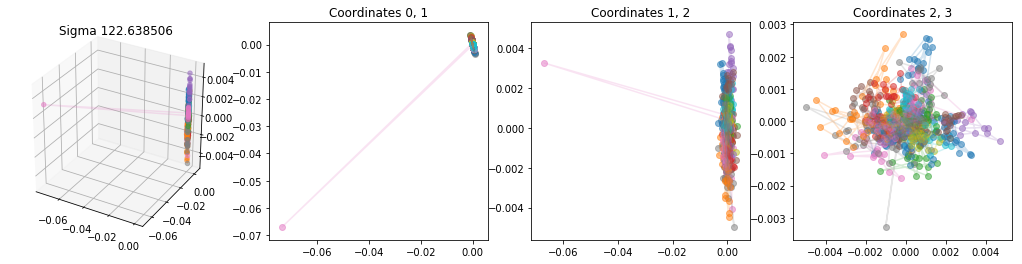

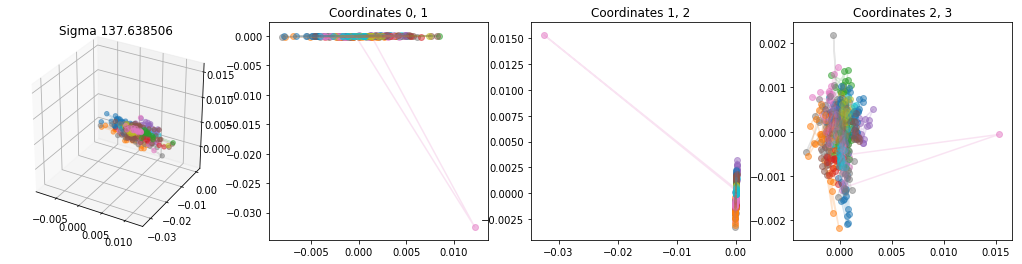

In [156]:
# We'll need to find an appropriate sigma again:
dists = pdist(scene_flat)
for sigdif in range(-1, 4):
    sig = np.median(dists) + 15 * sigdif
    [dif_map, dif_vals] = diffmap(scene_flat, sig, 1, 4)
    
    fig = plt.figure(figsize= [18, 4])
    ax0 = fig.add_subplot(1, 4, 1, projection='3d')
    ax0.set_title("Sigma %f" % sig)
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("Coordinates 0, 1")
    ax2 = fig.add_subplot(1, 4, 3)
    ax2.set_title("Coordinates 1, 2")
    ax3 = fig.add_subplot(1, 4, 4)
    ax3.set_title("Coordinates 2, 3")
    for scene in range(nScenes): 
        idx = [int(x) for x in (np.linspace(0, np.shape(dif_map)[0], n + 1)[:-1]) + scene]

        ax0.plot(dif_map[idx, 0], dif_map[idx, 1], dif_map[idx, 2], alpha = 0.2)
        ax0.scatter(dif_map[idx, 0], dif_map[idx, 1], dif_map[idx, 2], alpha = 0.5)

        ax.plot(dif_map[idx, 0], dif_map[idx, 1], alpha = 0.2 )
        ax.scatter(dif_map[idx, 0], dif_map[idx, 1], alpha = 0.5)

        ax2.plot(dif_map[idx, 1], dif_map[idx, 2], alpha = 0.2)
        ax2.scatter(dif_map[idx, 1], dif_map[idx, 2], alpha = 0.5)

        ax3.plot(dif_map[idx, 2], dif_map[idx, 3], alpha = 0.2)
        ax3.scatter(dif_map[idx, 2], dif_map[idx, 3],  alpha = 0.5)

In [157]:
classifier = GaussianNB() # KNeighborsClassifier() does just as well! 
# It seems like 105 might be better, but we'll stick with 100 to keep things consistent, 
# since it seems reasonable as well
[dif_map, dif_vals] = diffmap(scene_flat, 100, 1, 128)

results_dim = []
null_dim = []
for i in range(8):
    results = []
    nullresults = []
    
    dim = 2** i
    X = dif_map[:, :dim]
    y = scene_labels
    
    skf = StratifiedKFold(n_splits = 5) # 50 classes, only 17 examples each...
    skf.get_n_splits(X, y)
    for train_idx, test_idx in skf.split(X, y):
        trainx = X[train_idx, :]
        testx = X[test_idx, :]
        
        trainy = y[train_idx]
        testy = y[test_idx]
        
        classifier.fit(trainx, np.ravel(np.random.choice(trainy, len(trainy), replace = False)))
        nullpreds = classifier.predict(testx)
        nullresults.append(np.mean(nullpreds == testy))
        
        classifier.fit(trainx, trainy)
        preds = classifier.predict(testx)
        results.append(np.mean(preds == testy))
        
    print(dim, np.shape(X), np.shape(y), np.round(np.mean(results), 3), np.round(np.mean(nullresults), 3))
    results_dim.append(results)
    null_dim.append(nullresults)

1 (850, 1) (850,) 0.068 0.014
2 (850, 2) (850,) 0.081 0.017
4 (850, 4) (850,) 0.367 0.014
8 (850, 8) (850,) 0.465 0.019
16 (850, 16) (850,) 0.54 0.02
32 (850, 32) (850,) 0.614 0.032
64 (850, 64) (850,) 0.615 0.019
128 (850, 128) (850,) 0.575 0.025


In [158]:
results_dim

[[0.08, 0.075, 0.06, 0.06, 0.06666666666666667],
 [0.085, 0.095, 0.08666666666666667, 0.05333333333333334, 0.08666666666666667],
 [0.355, 0.405, 0.32, 0.37333333333333335, 0.38],
 [0.46, 0.51, 0.4266666666666667, 0.43333333333333335, 0.49333333333333335],
 [0.52, 0.54, 0.5533333333333333, 0.49333333333333335, 0.5933333333333334],
 [0.615, 0.6, 0.5933333333333334, 0.62, 0.64],
 [0.635, 0.595, 0.62, 0.6066666666666667, 0.62],
 [0.56, 0.57, 0.5866666666666667, 0.5666666666666667, 0.5933333333333334]]

Text(0.5, 1.0, 'Accuracy of scene prediction by \n number of dimensions used in diffusion embedding \n (with original data and Gaussian Naive Bayes model)')

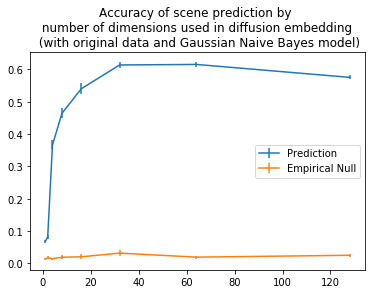

In [159]:
plt.errorbar(2 ** np.linspace(0, 8, 9)[:-1], np.mean(results_dim, axis = 1), np.std(results_dim, axis = 1)/np.sqrt(np.shape(results_dim)[1] - 1))
plt.errorbar(2 ** np.linspace(0, 8, 9)[:-1], np.mean(null_dim, axis = 1), np.std(null_dim, axis = 1)/np.sqrt(np.shape(null_dim)[1] - 1))
plt.legend(["Prediction", "Empirical Null"])
plt.title("Accuracy of scene prediction by \n number of dimensions used in diffusion embedding \n (with original data and Gaussian Naive Bayes model)")

In [160]:
# We can also work with the leftover "noise" data from the SRM model:
# X_i = W_i * S + e, so e = X_i - W_i * S

ind_data = [zmovie_data[0] - np.matmul(srm.w_[0], srm.s_)]
for pid in range(1, n):
    ind_data.append(movie_data[pid] - np.matmul(srm.w_[pid], srm.s_))

In [161]:
indscene_dat = [scene_voxelavg(ind_data[i], 0) for i in range(n)]
indscene_flat = flatdat(indscene_dat)

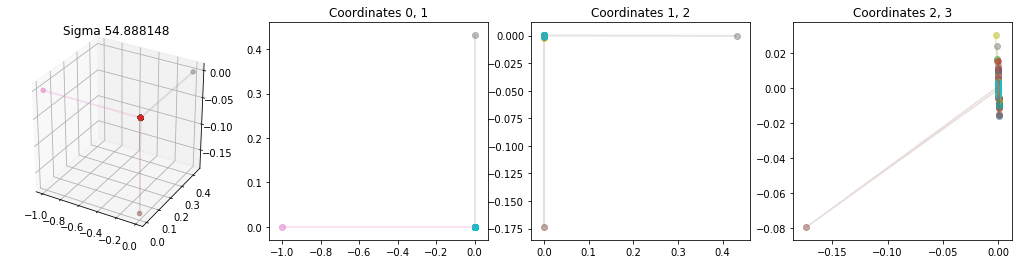

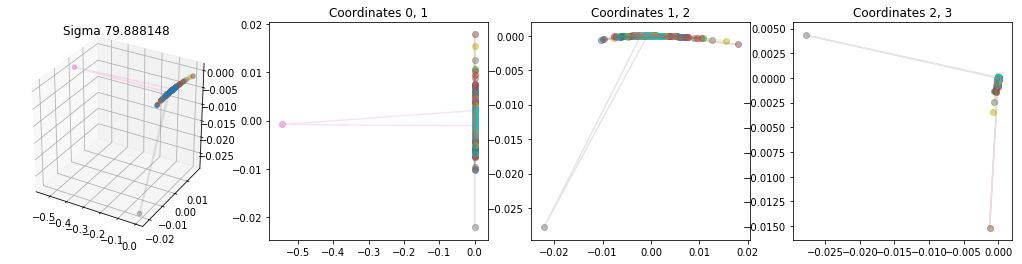

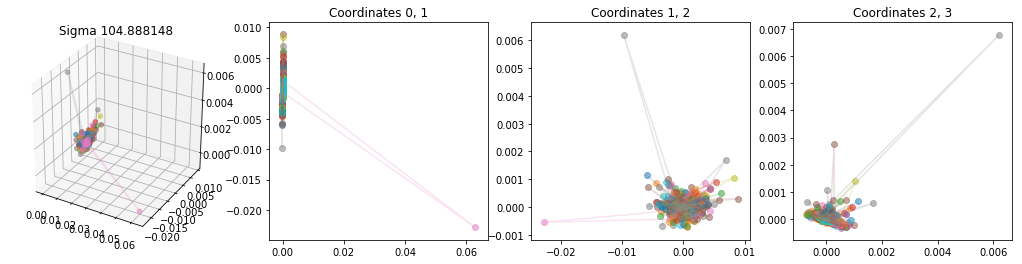

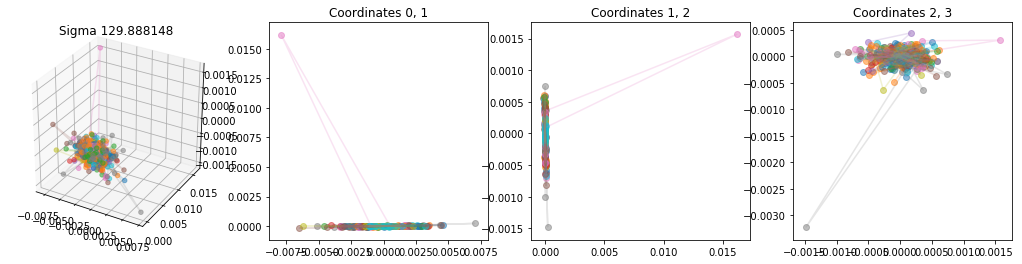

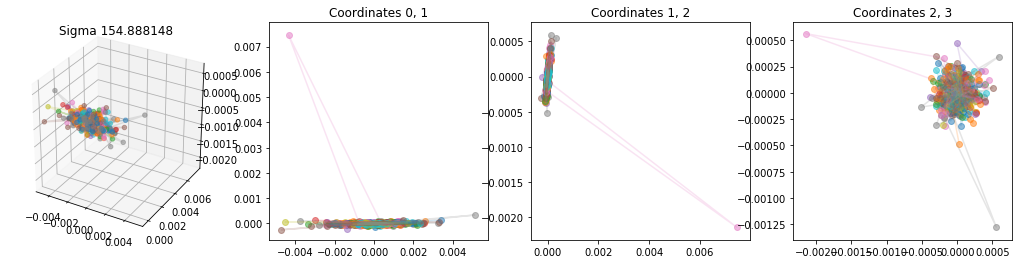

In [162]:
dists = pdist(indscene_flat)
for sigdif in range(5):
    sig = np.median(dists) + 25 * sigdif
    [dif_map, dif_vals] = diffmap(indscene_flat, sig, 1, 4)
    
    fig = plt.figure(figsize= [18, 4])
    ax0 = fig.add_subplot(1, 4, 1, projection='3d')
    ax0.set_title("Sigma %f" % sig)
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("Coordinates 0, 1")
    ax2 = fig.add_subplot(1, 4, 3)
    ax2.set_title("Coordinates 1, 2")
    ax3 = fig.add_subplot(1, 4, 4)
    ax3.set_title("Coordinates 2, 3")
    for scene in range(nScenes): 
        idx = [int(x) for x in (np.linspace(0, np.shape(dif_map)[0], n + 1)[:-1]) + scene]

        ax0.plot(dif_map[idx, 0], dif_map[idx, 1], dif_map[idx, 2], alpha = 0.2)
        ax0.scatter(dif_map[idx, 0], dif_map[idx, 1], dif_map[idx, 2], alpha = 0.5)

        ax.plot(dif_map[idx, 0], dif_map[idx, 1], alpha = 0.2 )
        ax.scatter(dif_map[idx, 0], dif_map[idx, 1], alpha = 0.5)

        ax2.plot(dif_map[idx, 1], dif_map[idx, 2], alpha = 0.2)
        ax2.scatter(dif_map[idx, 1], dif_map[idx, 2], alpha = 0.5)

        ax3.plot(dif_map[idx, 2], dif_map[idx, 3], alpha = 0.2)
        ax3.scatter(dif_map[idx, 2], dif_map[idx, 3],  alpha = 0.5)

In [163]:
# Again, we'll stick with 100
classifier = GaussianNB() 
[dif_map, dif_vals] = diffmap(indscene_flat, 100, 1, 128)

results_dim = []
null_dim = []
for i in range(8):
    results = []
    nullresults = []
    
    dim = 2 ** i
    X = dif_map[:, :dim]
    y = scene_labels
    
    skf = StratifiedKFold(n_splits = 5) # 50 classes, only 17 examples each...
    skf.get_n_splits(X, y)
    for train_idx, test_idx in skf.split(X, y):
        trainx = X[train_idx, :]
        testx = X[test_idx, :]
        
        trainy = y[train_idx]
        testy = y[test_idx]
        
        classifier.fit(trainx, np.ravel(np.random.choice(trainy, len(trainy), replace = False)))
        nullpreds = classifier.predict(testx)
        nullresults.append(np.mean(nullpreds == testy))
        
        classifier.fit(trainx, trainy)
        preds = classifier.predict(testx)
        results.append(np.mean(preds == testy))
        
    print(dim, np.shape(X), np.shape(y), np.round(np.mean(results), 3), np.round(np.mean(nullresults), 3))
    results_dim.append(results)
    null_dim.append(nullresults)
results_dim

1 (850, 1) (850,) 0.02 0.02
2 (850, 2) (850,) 0.023 0.018
4 (850, 4) (850,) 0.023 0.017
8 (850, 8) (850,) 0.038 0.023
16 (850, 16) (850,) 0.037 0.015
32 (850, 32) (850,) 0.051 0.013
64 (850, 64) (850,) 0.069 0.03
128 (850, 128) (850,) 0.085 0.029


[[0.015, 0.01, 0.02666666666666667, 0.02666666666666667, 0.02],
 [0.02, 0.02, 0.02666666666666667, 0.02666666666666667, 0.02],
 [0.04, 0.02, 0.02, 0.03333333333333333, 0.0],
 [0.04, 0.03, 0.04666666666666667, 0.04666666666666667, 0.02666666666666667],
 [0.035, 0.025, 0.02666666666666667, 0.06, 0.04],
 [0.055, 0.055, 0.05333333333333334, 0.04666666666666667, 0.04666666666666667],
 [0.07, 0.08, 0.06666666666666667, 0.06, 0.06666666666666667],
 [0.1, 0.09, 0.11333333333333333, 0.05333333333333334, 0.06666666666666667]]

Text(0.5, 1.0, 'Accuracy of scene prediction by \n number of dimensions used in diffusion embedding \n (with shared signal subtracted, in original data space)')

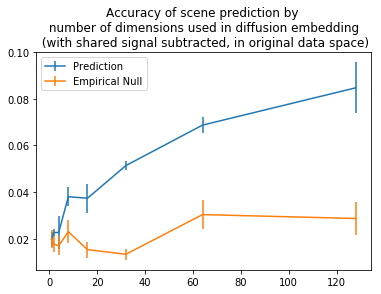

In [164]:
plt.errorbar(2 ** np.linspace(0, 8, 9)[:-1], np.mean(results_dim, axis = 1), np.std(results_dim, axis = 1)/np.sqrt(np.shape(results_dim)[1] - 1))
plt.errorbar(2 ** np.linspace(0, 8, 9)[:-1], np.mean(null_dim, axis = 1), np.std(null_dim, axis = 1)/np.sqrt(np.shape(null_dim)[1] - 1))
plt.legend(["Prediction", "Empirical Null"])
plt.title("Accuracy of scene prediction by \n number of dimensions used in diffusion embedding \n (with shared signal subtracted, in original data space)")

In [ ]:
# We see that the predictions of the individual data do a very poor job - this is consistent with our prediction that
# the information that is relevant to determine the scene being viewed is encoded in a signal that is shared among participants.
# One possible reason why we saw better performance from the embeddings of the shared space data compared to the original 
# data is that although it does not contain more information, it helps separate the signal from the noise, thus providing 
# the model better quality data to learn from. 
# Through this project, we have thus seen that while we cannot easily distinguish between brain states associated with later 
# recall (possibly because memory, a post-experience process, has a lot to do with it), we can distinguish brain states,
# even based on complex events that are different in a variety of ways (e.g. audio and visual input), to a fairly high accuracy- 
# even with just a few dimensions (we see a plateau at around 50 dimensions), compared to the 26k voxels in the whole brain ROI.
# In fact, the diffusion mapping shows that similarities in brain signals for events are much greater than differences 
# in brain signals between participants (as we saw that their embeddings were all generally similar), which 
# may have a wide variety of applications in deciphering neural signals with general-purpose methods. 
# There are a lot of future directions of exploration from here - for instance, there was one especially notable 
# outlier observation (corresponding to one scene from a single participant). What is the underlying cause for these
# differences? 